# Imports

In [15]:
import pandas
import numpy
import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import seaborn
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Dataset Creation

## Downloading Data

1. Specificy source urls and destination local files in a dictionary
2. Check that the folder exists, if not create it
3. Download the data if it is not available

In [2]:
SourceURLs = {'MajorRoadsEmissions': 'https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/f2129345-06d4-4d3d-8304-d65fcdeb118e/LAEI2019-nox-pm-co2-major-roads-link-emissions.zip',
              'RoadTraffic': 'https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/3a00296b-c88b-4de0-8336-b127034cc07b/laei-2019-major-roads-vkm-flows-speeds.zip'
              }

LocalFiles = {'MajorRoadsEmissions': 'Data/LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx',
              'RoadTraffic': 'Data/laei-2019-major-roads-vkm-flows-speeds.xlsx'}

# Check if data folder exists, if not create it
if not os.path.exists('Data'):
    os.makedirs('Data')

# Check if data is already downloaded, if not download it
for file in LocalFiles:
    if os.path.exists(LocalFiles[file]):
        print(f'File {LocalFiles[file]} already downloaded')
    else:
        print(f'Downloading {SourceURLs[file]}')
        resp = urlopen(SourceURLs[file])
        DocZip = ZipFile(BytesIO(resp.read()))
        DocZip.extractall('Data')

File Data/LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx already downloaded
File Data/laei-2019-major-roads-vkm-flows-speeds.xlsx already downloaded


## Loading Data

1. Load the data into a data frame
2. Limit the data to 2019

In [3]:
# Load LAEI Road Traffic Data
roadtraffic_df = pandas.read_excel(LocalFiles['RoadTraffic'], sheet_name='laei-2019-major-roads')

# Filter the dataset
roadtraffic_df = roadtraffic_df[roadtraffic_df['Year'] == 2019]

# check the shape and first few rows of the dataframe
print(roadtraffic_df.shape)
roadtraffic_df.head()

(79437, 48)


,Year,TOID,LAEI Zone,Borough,Road Classification,AADT Motorcycle,AADT Taxi,AADT Petrol Car,AADT Diesel Car,AADT Electric Car,...,VKM Electric LGV,VKM 2019 - HGVs - Rigid - 2 Axles,VKM 2019 - HGVs - Rigid - 3 Axles,VKM 2019 - HGVs - Rigid - 4 or more Axles,VKM 2019 - HGVs - Articulated - 3 to 4 Axles,VKM 2019 - HGVs - Articulated - 5 Axles,VKM 2019 - HGVs - Articulated - 6 Axles,VKM 2019 - Buses,VKM 2019 - Coaches,VKM 2019 - Total
0,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,50,3659,736,1451,531,2759,3659,-,327,231749
1,2019,osgb4000000027908760,Non-GLA,Non-GLA,A Road,68,10,3049,2107,18,...,78,1718,344,687,258,1289,1718,-,1160,295268
2,2019,osgb4000000027987795,Non-GLA,Non-GLA,A Road,131,15,5752,3976,34,...,57,1377,275,551,192,1042,1377,-,7746,158880
3,2019,osgb4000000027869099,Non-GLA,Non-GLA,A Road,178,14,7280,5031,43,...,2066,63666,12679,25359,9172,48019,63396,-,97388,4851571
4,2019,osgb4000000030443012,Non-GLA,Non-GLA,A Road,178,34,8433,5828,50,...,11,465,94,185,67,352,465,-,446,43270


In [4]:
# Load LAEI Major Road Emissions data
    
# read all sheets from list into an ordered dictionary    
excelsheets = pandas.ExcelFile(LocalFiles['MajorRoadsEmissions']).sheet_names
emissions_majorroads_dict =  pandas.read_excel(LocalFiles['MajorRoadsEmissions'], sheet_name= excelsheets)

# concatenate all sheets into a single dataframe
emissions_majorroads_df = pandas.concat(emissions_majorroads_dict, axis=0, ignore_index=True)

# Drop Columns that are not 2019 data
columnstokeep = emissions_majorroads_df.columns
for a in columnstokeep:
    if '2025' in a or '2030' in a:
        columnstokeep = columnstokeep.drop(a)
        emissions_majorroads_df = emissions_majorroads_df[columnstokeep]

# check the shape and first few rows of the dataframe
print(emissions_majorroads_df.shape)
emissions_majorroads_df.head()

(635512, 20)


,TOID,pollutant,emissions-units,Road-Car-Petrol-2019,Road-Car-Diesel-2019,Road-Car-Electric-2019,Road-PHV-Petrol-2019,Road-PHV-Diesel-2019,Road-PHV-Electric-2019,Road-LGV-Petrol-2019,Road-LGV-Diesel-2019,Road-LGV-Electric-2019,Road-HGV-Rigid-2019,Road-HGV-Articulated-2019,Road-TfL-Bus-2019,Road-Non-TfL-Bus-or-Coach-2019,Road-Taxi-2019,Road-Motorcycle-2019,Road-Total-2019,pm-source
0,osgb4000000027865913,nox,tonnes/year,1.590568,6.993015,0.0,0.030372,0.214953,0.0,0.008550,6.882164,0.0,0.858378,0.674338,0.0,0.448031,0.030217,0.077711,17.808298,NaN
1,osgb4000000027865914,nox,tonnes/year,1.565236,7.108021,0.0,0.034120,0.250065,0.0,0.010989,9.392835,0.0,1.042228,0.819567,0.0,0.503748,0.050126,0.083772,20.860706,NaN
2,osgb4000000027865915,nox,tonnes/year,1.031740,10.018715,0.0,0.079560,0.540788,0.0,0.010269,9.835178,0.0,1.771826,2.681607,0.0,0.247354,0.045132,0.059342,26.321512,NaN
3,osgb4000000027865916,nox,tonnes/year,1.146019,11.792383,0.0,0.075438,0.537094,0.0,0.010219,10.886653,0.0,1.955103,2.958598,0.0,0.258160,0.035638,0.076658,29.731963,NaN
4,osgb4000000027865917,nox,tonnes/year,0.686157,6.986898,0.0,0.044834,0.316394,0.0,0.007327,7.658349,0.0,1.094813,1.657397,0.0,0.188234,0.039542,0.045465,18.725408,NaN


## Joining the data into a single dataset

1. Left join the two datasets into a single dataset

In [5]:
# Join the dataframes
emissions_df = pandas.merge(roadtraffic_df, emissions_majorroads_df, on='TOID', how='left')

print(emissions_df.shape)
emissions_df.head()

(635153, 67)


,Year,TOID,LAEI Zone,Borough,Road Classification,AADT Motorcycle,AADT Taxi,AADT Petrol Car,AADT Diesel Car,AADT Electric Car,...,Road-LGV-Diesel-2019,Road-LGV-Electric-2019,Road-HGV-Rigid-2019,Road-HGV-Articulated-2019,Road-TfL-Bus-2019,Road-Non-TfL-Bus-or-Coach-2019,Road-Taxi-2019,Road-Motorcycle-2019,Road-Total-2019,pm-source
0,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,0.026410,0.000000e+00,0.004145,0.005330,0.0,0.000410,0.000381,0.000581,0.086293,NaN
1,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,0.000351,0.000000e+00,0.000062,0.000093,0.0,0.000005,0.000006,0.000017,0.001370,exhaust
2,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,0.000190,4.181048e-07,0.000138,0.000164,0.0,0.000008,0.000002,0.000006,0.001555,brake wear
3,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,0.000226,4.955241e-07,0.000089,0.000231,0.0,0.000004,0.000002,0.000006,0.001784,tyre wear
4,2019,osgb4000000027947700,Non-GLA,Non-GLA,A Road,112,15,5470,3780,32,...,0.000333,0.000000e+00,0.000059,0.000089,0.0,0.000004,0.000006,0.000016,0.001301,exhaust


## Quick Data Validation and Cleaning

Minus a few non numerical values, the data looks very good

Given the nature of the data, _fudging_ missing data doesn't really make sense

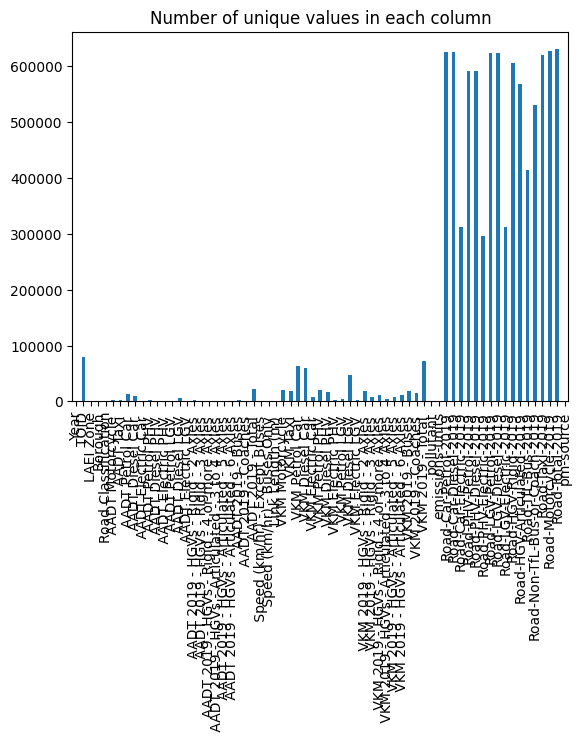

Year                                   1
TOID                               79437
LAEI Zone                              4
Borough                               34
Road Classification                   12
                                   ...  
Road-Non-TfL-Bus-or-Coach-2019    531430
Road-Taxi-2019                    620499
Road-Motorcycle-2019              627649
Road-Total-2019                   630096
pm-source                              3
Length: 67, dtype: int64
TOID
TOID
osgb4000000030418875    8
osgb4000000027947700    8
osgb4000000027908760    8
osgb4000000027987795    8
osgb4000000027869099    8
                       ..
osgb4000000030421503    1
osgb5000005128772013    1
osgb5000005132587507    1
osgb5000005126159288    1
osgb5000005126159285    1
Name: count, Length: 79437, dtype: int64

LAEI Zone
LAEI Zone
Outer London      322375
Inner London      187078
Non-GLA            98500
Central London     27200
Name: count, dtype: int64

Borough
Borough
Non-GLA                

In [6]:
# Display the number of unique values in each column
emissions_df.nunique().plot(kind='bar')
pyplot.title('Number of unique values in each column')
pyplot.show()

# Display the number of unique values in each column
print(emissions_df.nunique())

# Display the unique values and their frequencies
for column in emissions_df.select_dtypes(include=['object']).columns:
    print(column)
    print(emissions_df[column].value_counts())
    print()


In [7]:
# Data cleaning

# replace all values that are ' -   ' with NaN
clean_df = emissions_df.replace(' -  ', None, regex=True)

# Remove leading / trailing spaces from column names
clean_df.columns = clean_df.columns.str.strip()

C:\Users\FAB\AppData\Local\Temp\ipykernel_8432\39000336.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_df = emissions_df.replace(' -  ', None, regex=True)


## Classify Columns into labels and targets

- Break into two sets of labels, speed and polution
- Create one set of targets relative to polution amount

In [8]:
df_columns = clean_df.columns
print(df_columns)

Index(['Year', 'TOID', 'LAEI Zone', 'Borough', 'Road Classification',
       'AADT Motorcycle', 'AADT Taxi', 'AADT Petrol Car', 'AADT Diesel Car',
       'AADT Electric Car', 'AADT Petrol PHV', 'AADT Diesel PHV',
       'AADT Electric PHV', 'AADT Petrol LGV', 'AADT Diesel LGV',
       'AADT Electric LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles',
       'AADT 2019 - HGVs - Rigid - 3 Axles',
       'AADT 2019 - HGVs - Rigid - 4 or more Axles',
       'AADT 2019 - HGVs - Articulated - 3 to 4 Axles',
       'AADT 2019 - HGVs - Articulated - 5 Axles',
       'AADT 2019 - HGVs - Articulated - 6 Axles', 'AADT 2019 - Buses',
       'AADT 2019 - Coaches', 'AADT 2019 - Total',
       'Speed (km/hr) - Except Buses', 'Speed (km/hr) - Buses Only',
       'Link Length (m)', 'VKM Motorcycle', 'VKM Taxi', 'VKM Petrol Car',
       'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol PHV',
       'VKM Diesel PHV', 'VKM Electric PHV', 'VKM Petrol LGV',
       'VKM Diesel LGV', 'VKM Electric LGV',
       'VKM 2

In [9]:
# Labels
VKM_Label = []
AADT_Label = []
# Target
Target = []
for a in df_columns:
    if 'VKM' in a:
        VKM_Label = VKM_Label + [a]
    elif 'AADT' in a:
        AADT_Label = AADT_Label + [a]
    elif '2019' in a:
        Target = Target + [a]

print('VKM_Label:', VKM_Label)
print('AADT_Label:', AADT_Label)
print('Target:', Target)

VKM_Label: ['VKM Motorcycle', 'VKM Taxi', 'VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol PHV', 'VKM Diesel PHV', 'VKM Electric PHV', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM Electric LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', 'VKM 2019 - HGVs - Rigid - 3 Axles', 'VKM 2019 - HGVs - Rigid - 4 or more Axles', 'VKM 2019 - HGVs - Articulated - 3 to 4 Axles', 'VKM 2019 - HGVs - Articulated - 5 Axles', 'VKM 2019 - HGVs - Articulated - 6 Axles', 'VKM 2019 - Buses', 'VKM 2019 - Coaches', 'VKM 2019 - Total']
AADT_Label: ['AADT Motorcycle', 'AADT Taxi', 'AADT Petrol Car', 'AADT Diesel Car', 'AADT Electric Car', 'AADT Petrol PHV', 'AADT Diesel PHV', 'AADT Electric PHV', 'AADT Petrol LGV', 'AADT Diesel LGV', 'AADT Electric LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles', 'AADT 2019 - HGVs - Rigid - 3 Axles', 'AADT 2019 - HGVs - Rigid - 4 or more Axles', 'AADT 2019 - HGVs - Articulated - 3 to 4 Axles', 'AADT 2019 - HGVs - Articulated - 5 Axles', 'AADT 2019 - HGVs - Articulated - 6 Ax

In [10]:
# Remove irrelevent labels
VKM_Label.remove('VKM 2019 - Total')
AADT_Label.remove('AADT 2019 - Total')
Target.remove('Road-Total-2019')

## Visualise the Data

- Check if there is any correlation between the labels and targets

In [11]:
# save plot to visuals folder
if not os.path.exists('charts'):
    os.makedirs('charts')

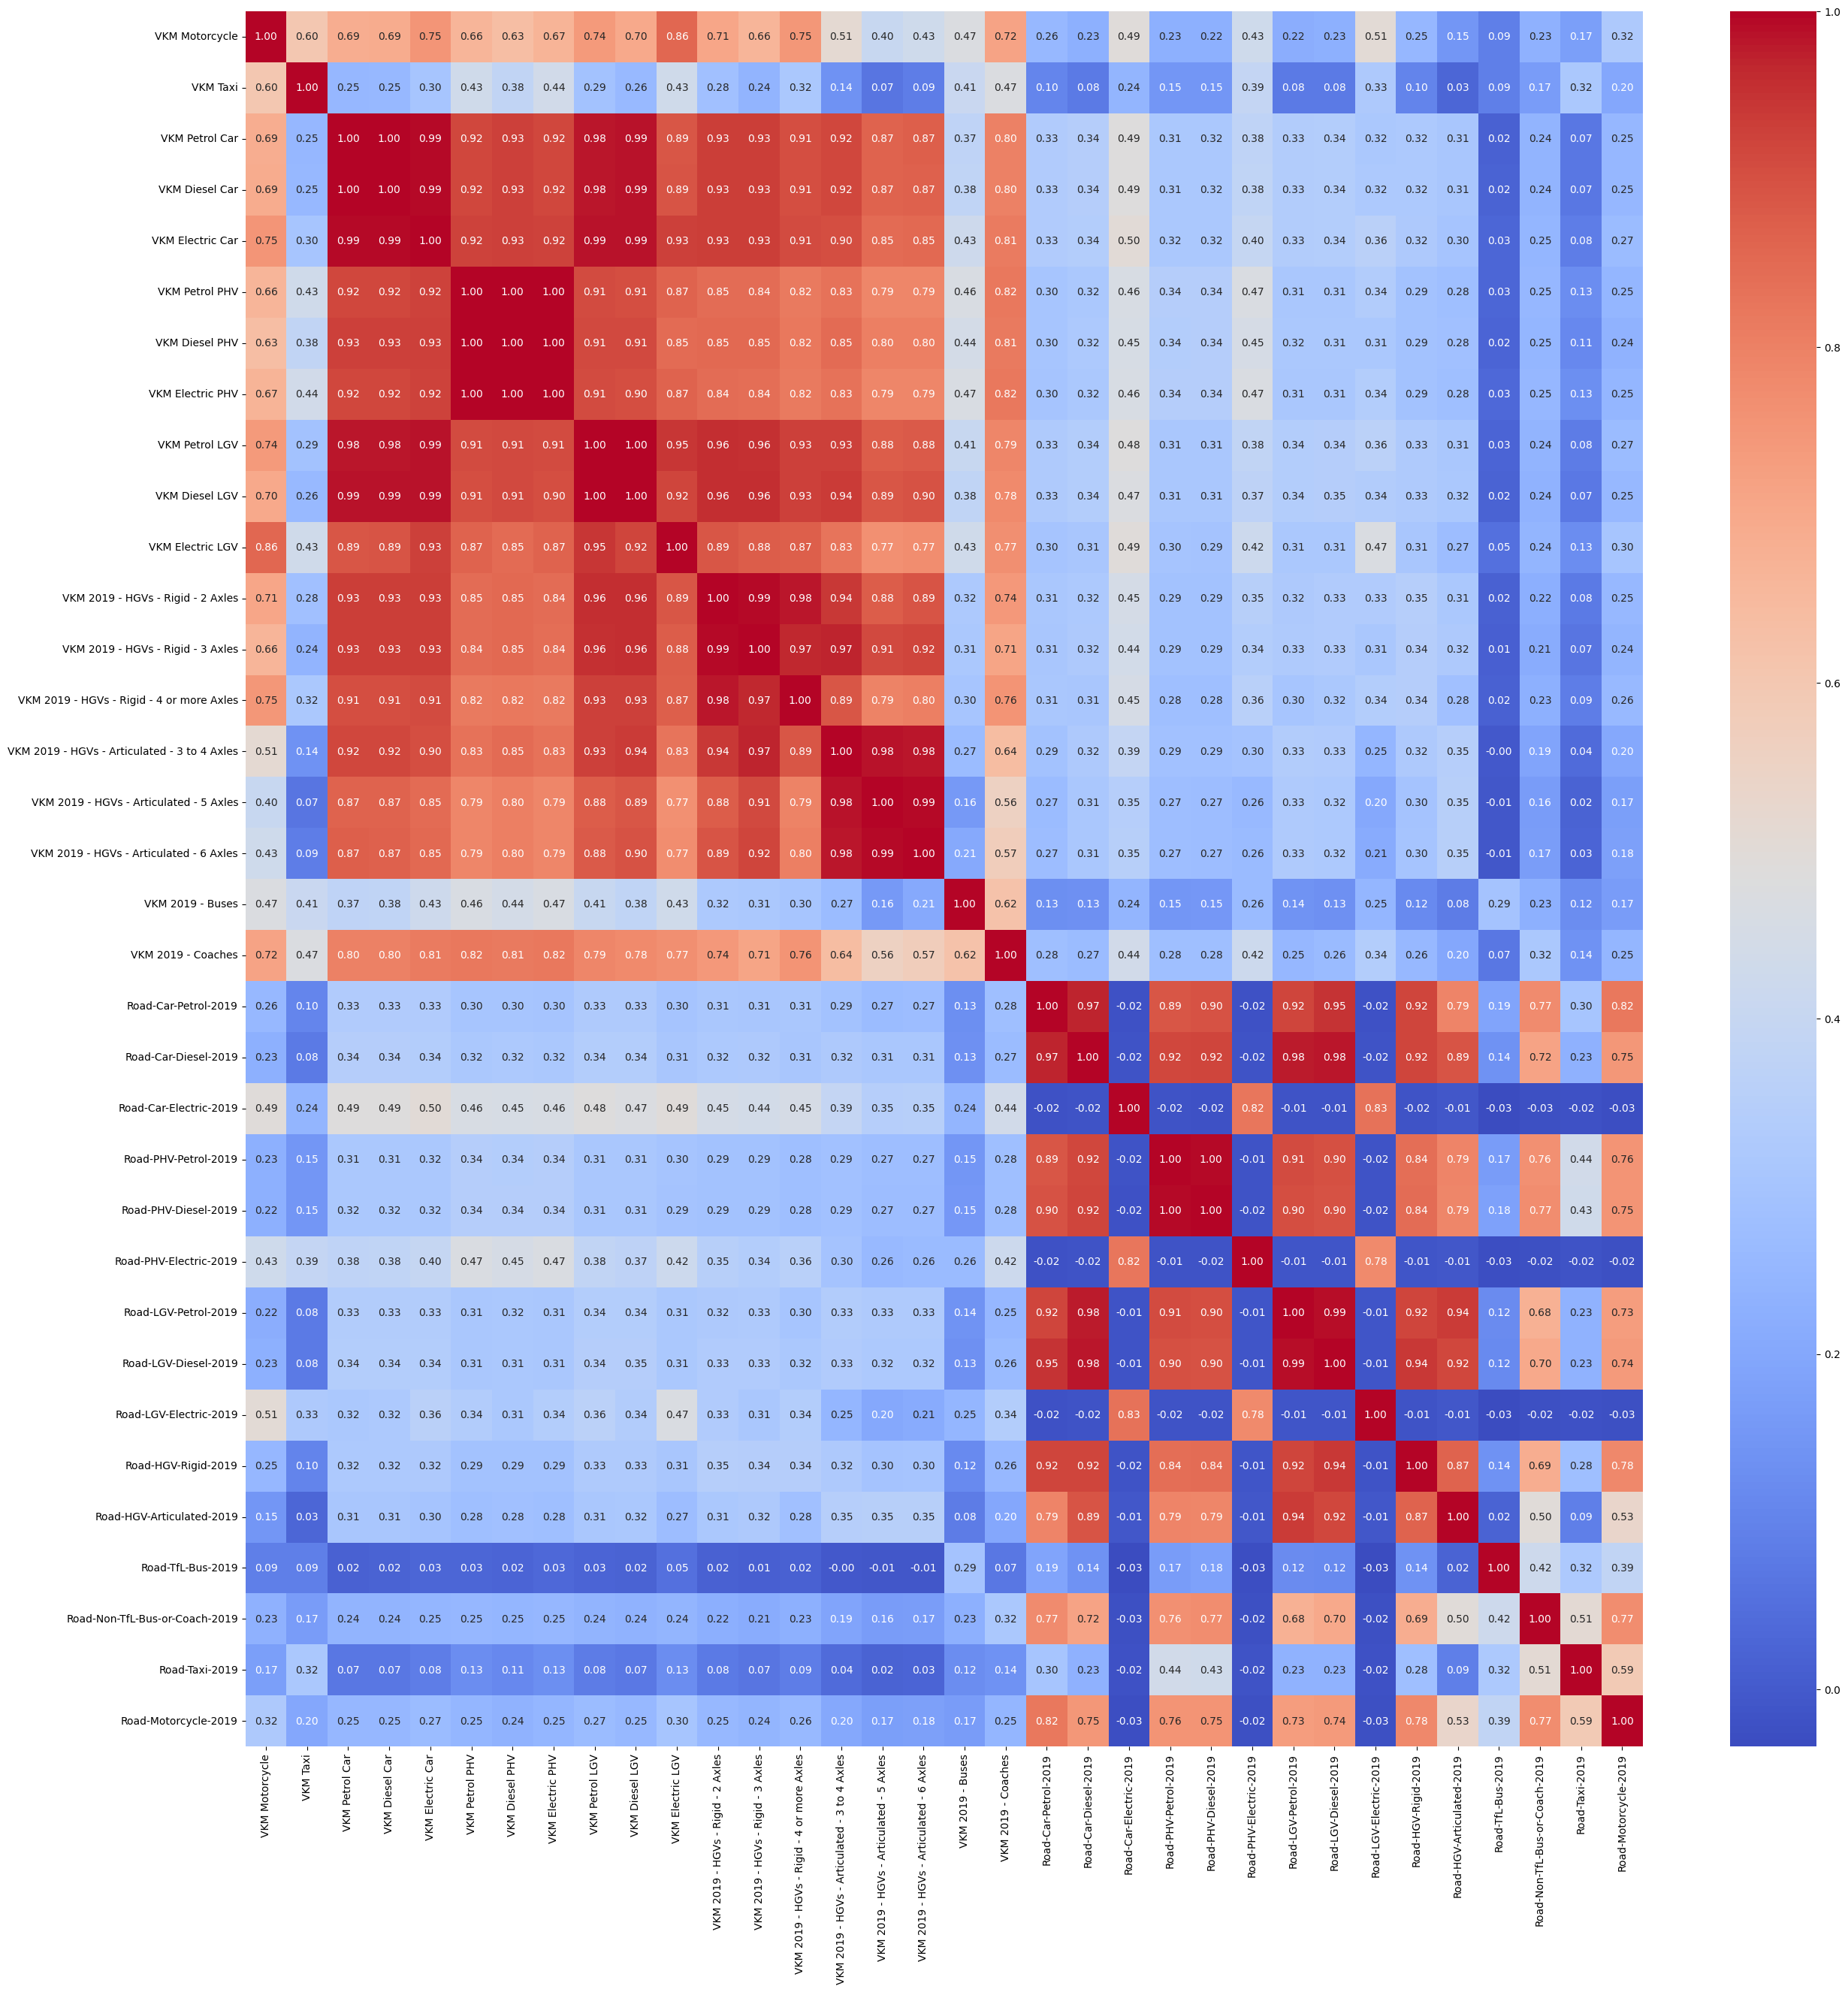

In [12]:
# plot the correlation matrix
VKM_correlation = clean_df[VKM_Label + Target].corr()
pyplot.figure(figsize=(30, 30))
seaborn.heatmap(VKM_correlation, annot=True, fmt='.2f', cmap='coolwarm')

pyplot.savefig('charts/vkm_correlation_matrix.png')

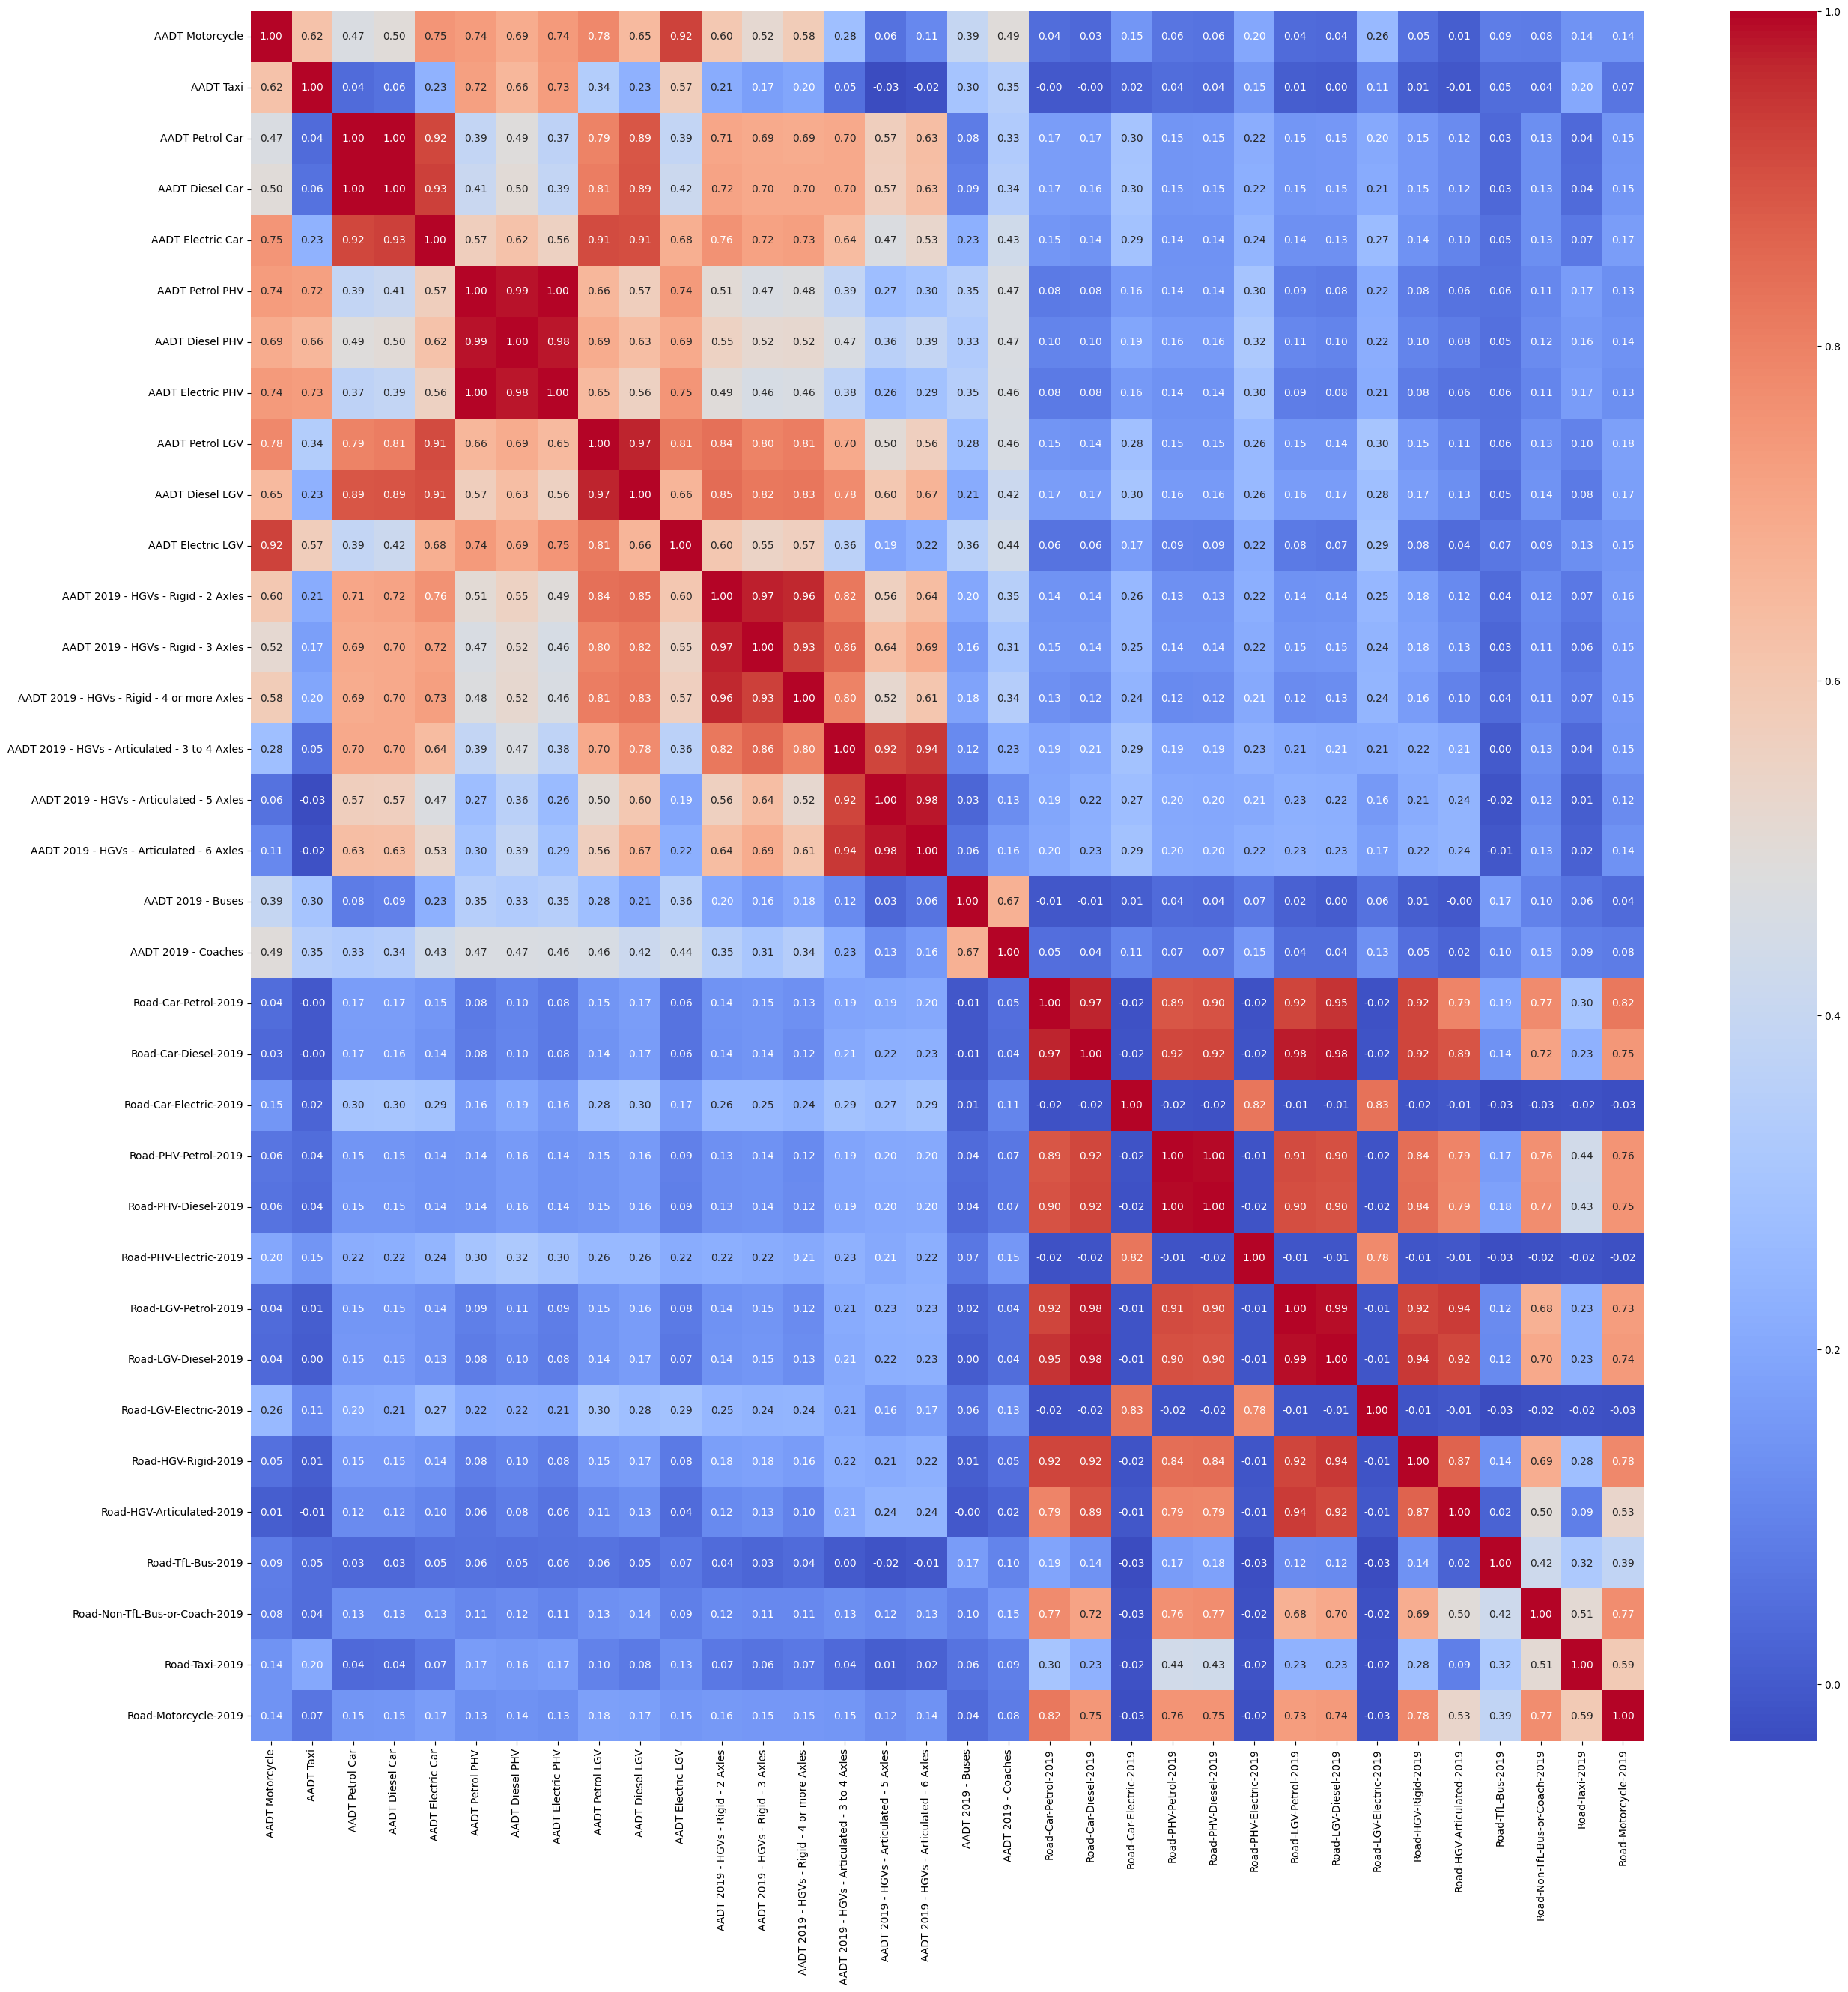

In [13]:
# plot the correlation matrix
AADT_correlation = clean_df[AADT_Label + Target].corr()
pyplot.figure(figsize=(30, 30))
seaborn.heatmap(AADT_correlation, annot=True, fmt='.2f', cmap='coolwarm')

pyplot.savefig('charts/aadt_correlation_matrix.png')

In [19]:


# Alternatively, if you want to encode 'TOID', you can use Label Encoding
le_toid = LabelEncoder()
clean_df['TOID'] = le_toid.fit_transform(clean_df['TOID'])
# Then use it in your feature set by skipping the drop statement above.

# Encode categorical variables
categorical_cols = ['Borough', 'Road Classification']  # Add more if needed
for col in categorical_cols:
    le = LabelEncoder()
    clean_df[col] = le.fit_transform(clean_df[col])

NameError: name 'df' is not defined

In [17]:
# Define target variable (Road-LGV-Diesel-2019)
targets = ['AADT Motorcycle', 'AADT Taxi', 'AADT Petrol Car', 'AADT Diesel Car', 
                  'AADT Electric Car', 'Road-LGV-Diesel-2019', 'Road-HGV-Rigid-2019', 
                  'Road-TfL-Bus-2019']

# Step 4: Define features (X) and target (y)
x = clean_df.drop(targets, axis=1)  # Replace 'target_column' with your target variable
y = clean_df[targets]

# Split the dataset into training set and testing set 
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size= 0.25 , random_state=50)

In [18]:
# Scalling the Features : useful for SVR implemenation
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaler = scaler.transform(x_test)


ValueError: could not convert string to float: 'osgb4000000030313483'